In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from prophet import Prophet

# Import Data

In [53]:
mase = MeanAbsoluteScaledError(sp=4)
original = pd.read_csv('new_dataset/owid-covid-data-most-recent.csv')

df = pd.read_csv('multivariate.csv')
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date':'ds', 'new_deaths':'y'}, inplace=True)
df = df[df['ds'] < '2024-01-14']
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')

# impute missing values
# when total_cases is nan, set is to 0 
df['total_cases'] = df['total_cases'].fillna(0)
df['new_cases'] = df['new_cases'].fillna(0)
df['total_cases_per_million'] = df['total_cases_per_million'].fillna(0)
df['new_cases_per_million'] = df['new_cases_per_million'].fillna(0)
df = df.drop(columns = ['weekly_icu_admissions_per_million'], axis = 1, errors = 'ignore')
vaccine_columns = [col for col in df.columns if 'vaccin' in col]
# for the dates before december 11 2020, for the rows where the vaccine columns are nan, set them to 0
df.loc[df['ds'] < '2020-12-13', vaccine_columns] = df.loc[df['ds'] < '2020-12-13', vaccine_columns].fillna(111000000)
# remove rows where new_deaths_2_week_mean is nan
df = df.dropna(subset=['new_deaths_2_week_mean'])
# remove rows where new_deaths_4_week_max is nan
df = df.dropna(subset=['new_deaths_4_week_max'])
df = df.dropna(subset=['new_deaths_4_week_lag'])

multivar = df.copy()
multivar = pd.get_dummies(df)
multivar = multivar.set_index('ds')

In [ ]:
# time events

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07','2023-2-12']),
    'lower_window': -7,
    'upper_window': 1,
})
# Combine all events
events = pd.concat((superbowl))

# Take a look at the events data


In [54]:
# drop all rolling window and lag columns
multivar = multivar.drop(columns = ['new_cases_2_week_mean', 'new_cases_4_week_max', 'new_cases_4_week_lag', 'new_deaths_2_week_mean', 'new_deaths_4_week_max', 'new_deaths_4_week_lag','new_deaths_1_week_lag', 'new_deaths_2_week_lag',
       'new_deaths_4_week_mean', 'new_deaths_2_week_std',
       'new_deaths_4_week_std', 'new_deaths_2_week_max',
       'new_deaths_2_week_min', 'new_deaths_4_week_min',], axis = 1, errors = 'ignore')

def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['y']].join(lag1df)
    return df.fillna(0) 
multivar=process(multivar)

multivar = multivar.drop(columns = 'lag1_y')
multivar = multivar.sort_index()
train_size = int(len(multivar) * 0.7)
multivar_train, multivar_test = multivar[0:train_size], multivar[train_size:]
print(multivar_train.shape, multivar_test.shape)

(13894, 43) (5955, 43)


In [55]:
model_multivariate = Prophet(holidays=events)
for col in multivar_train.columns:
    if col not in ['ds', 'y']:
        model_multivariate.add_regressor(col)

model_multivariate.fit(multivar_train.reset_index())

17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing


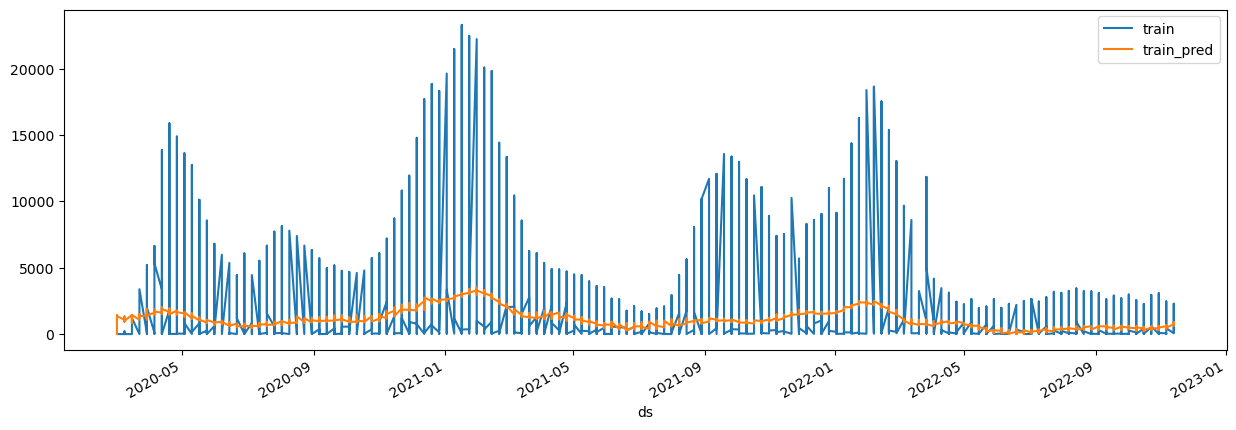

In [56]:
#train 
train_pred=model_multivariate.predict(multivar_train.reset_index()).set_index('ds')
train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([multivar_train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

(0.0, 5000.0)

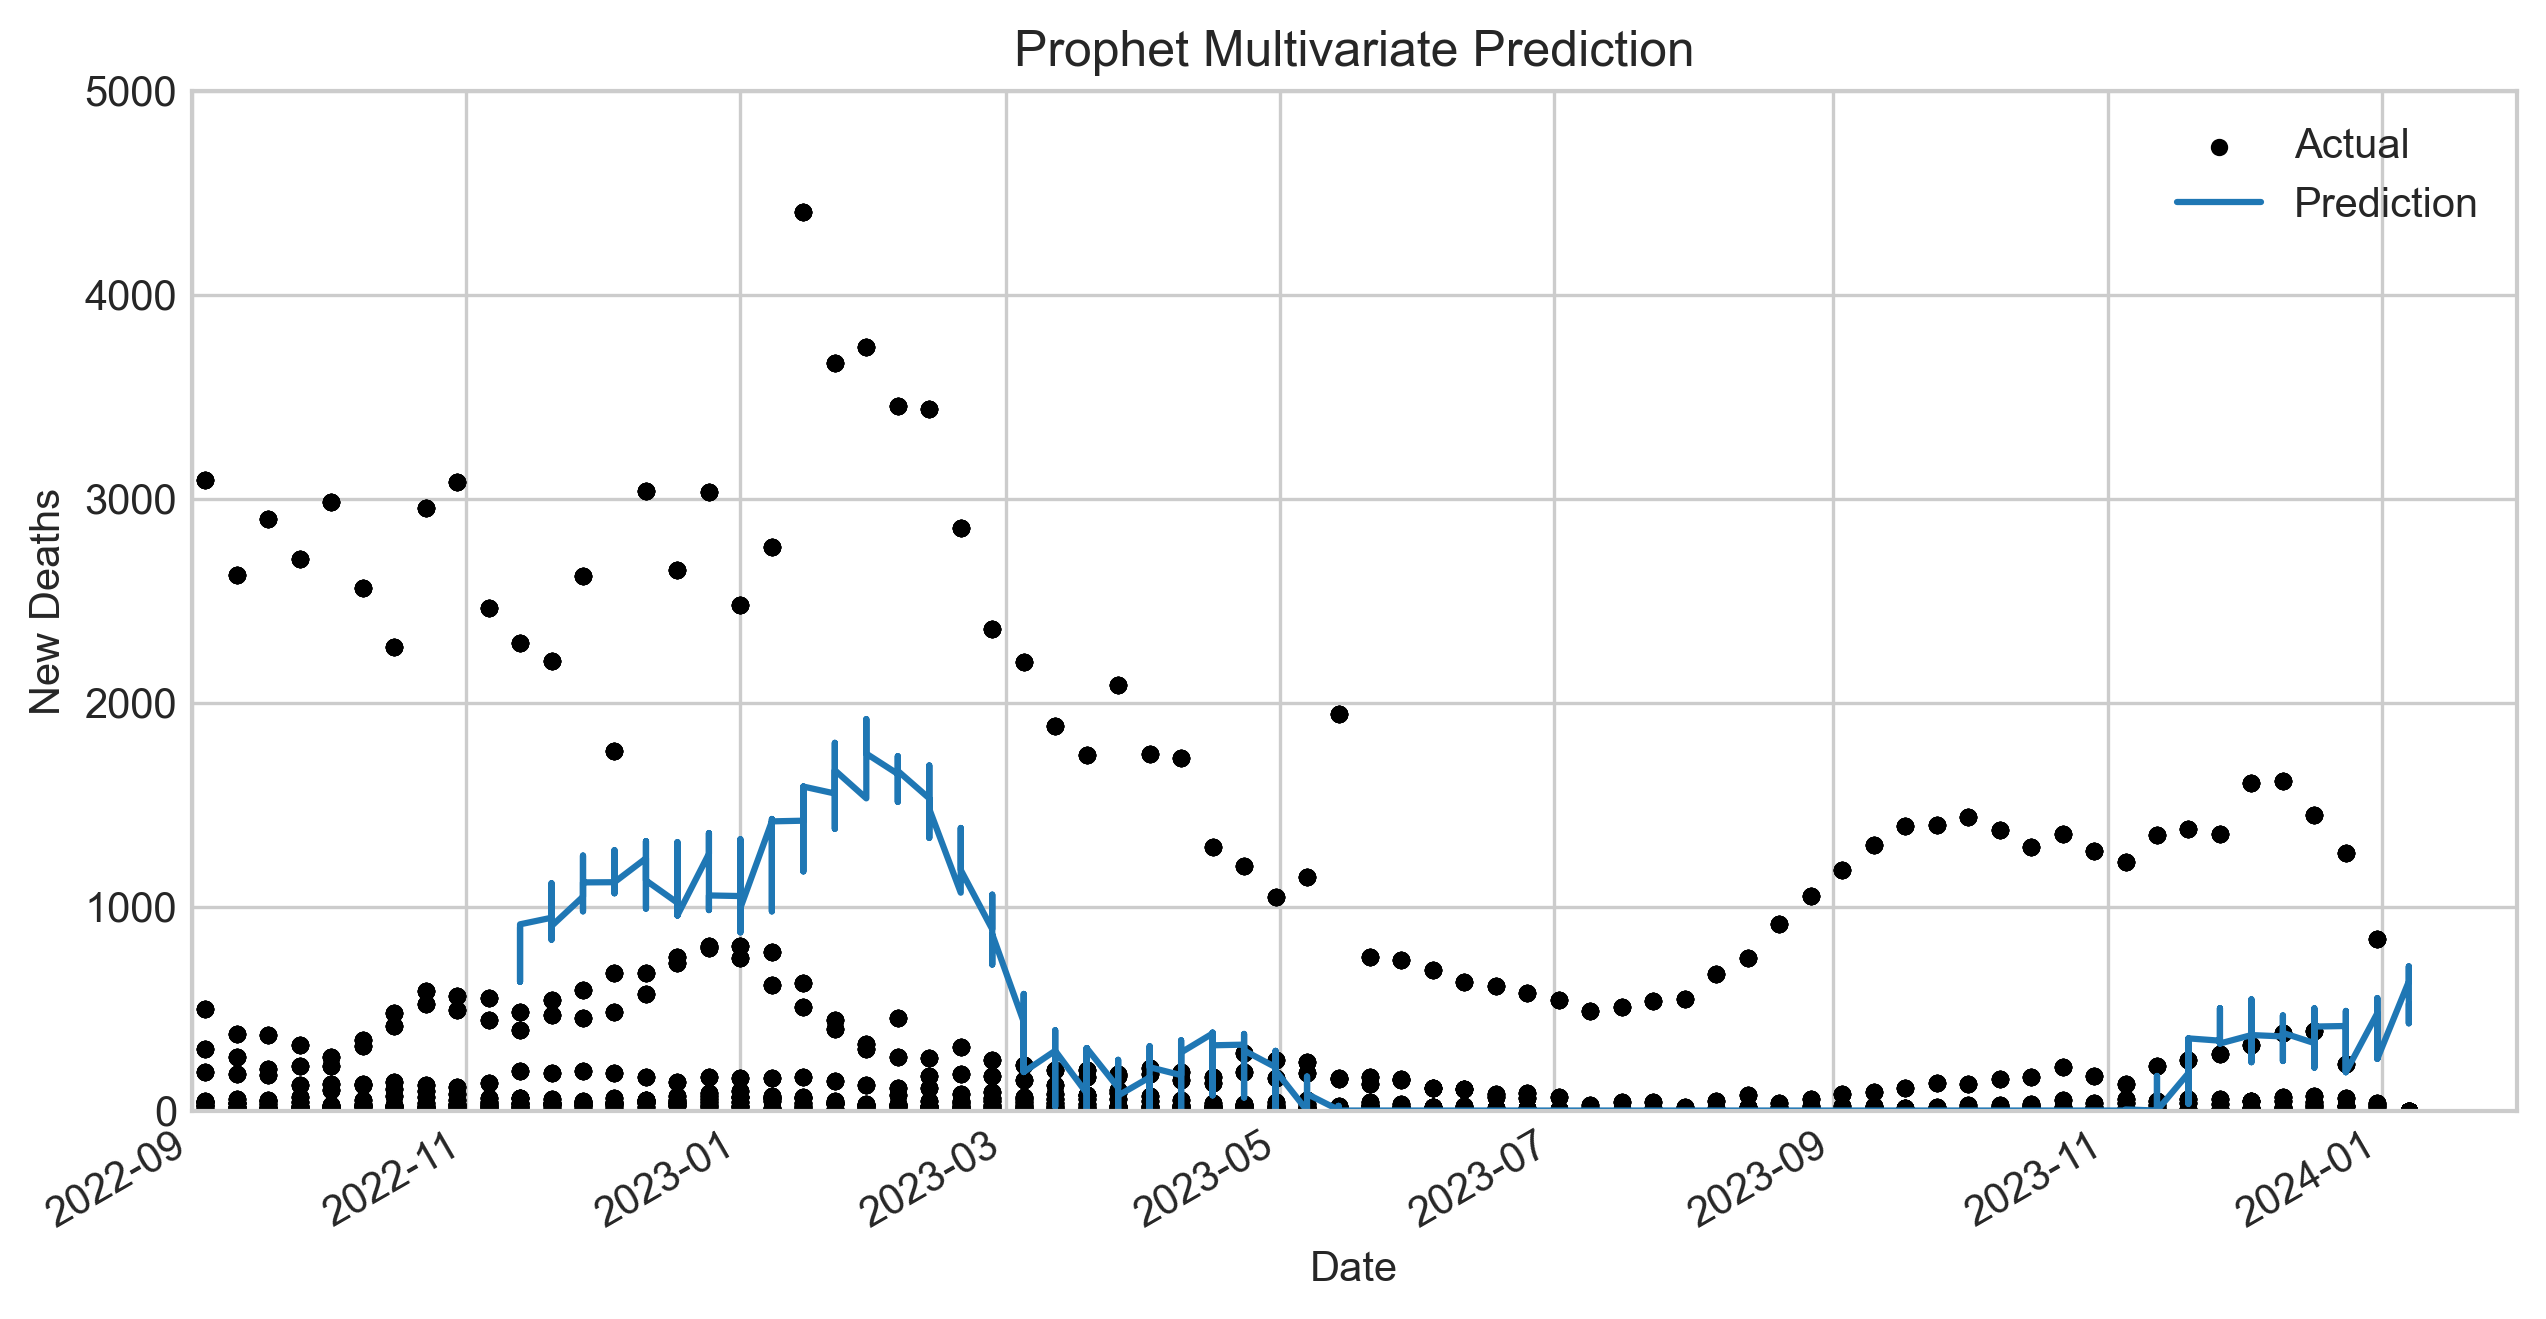

In [88]:
#pred 
test_pred=model_multivariate.predict(multivar_test.reset_index()).set_index('ds')
test_pred['yhat'] = np.maximum(test_pred['yhat'], 0) # clamp negtaive values
deaths = pd.concat([multivar_test['y'],test_pred['yhat']], axis=1)

plt.style.use('seaborn-v0_8-whitegrid')
# increase resolution
plt.figure(dpi=300)
plt.scatter(deaths.index, deaths['y'],color = 'black', s=10)
plt.scatter(multivar_train.index,multivar_train['y'], label='Actual', color = 'black', s=10)
plt.plot(deaths['yhat'], label='Prediction')
plt.legend()
# make plot from november 2022
import datetime
plt.xlim([datetime.date(2022, 9, 1), datetime.date(2024, 1, 31)])
plt.ylabel('New Deaths')
plt.xlabel('Date')
plt.title('Prophet Multivariate Prediction')
plt.gcf().autofmt_xdate()
fig = plt.gcf()
fig.set_size_inches(10, 5)
# limit max of y axis 
plt.ylim(0, 5000)


In [67]:
# eval 
evaluation = pd.DataFrame(columns = ['Model', 'MAE', 'MASE'])
# calculate MAE
baseline_mae = mean_absolute_error(multivar_test['y'], test_pred['yhat'])
mase = MeanAbsoluteScaledError(sp=13)
baseline_mase = mase(multivar_test['y'], test_pred['yhat'], y_train = multivar_train['y'])
evaluation = evaluation.append({'Model': 'Baseline', 'MAE': baseline_mae, 'MASE': baseline_mase}, ignore_index=True)

/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_8822/3551600844.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Model': 'Baseline', 'MAE': baseline_mae, 'MASE': baseline_mase}, ignore_index=True)


In [89]:
evaluation.to_csv('prophet_multivariate_evaluation.csv', index=False)